# Deblending

## Load Modules

In [ ]:
import os

import yaml

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import galcheat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

from maddeb.Deblender import Deblend, compute_residual
from maddeb.extraction import extract_cutouts
from maddeb.utils import get_data_dir_path, get_maddeb_config_path

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
with open(get_maddeb_config_path()) as f:
    maddeb_config = yaml.safe_load(f)

In [ ]:
import pickle

save_file_name = os.path.join(get_data_dir_path(), "example_blend.pkl")
with open(save_file_name, "rb") as pickle_file:
    blend = pickle.load(pickle_file)
max_number = (
    20  # max number of galaxies in the 4 fields (This was set during the simulations)
)
linear_norm_coeff = 10000  # linear normalization coefficient

## Visualize data

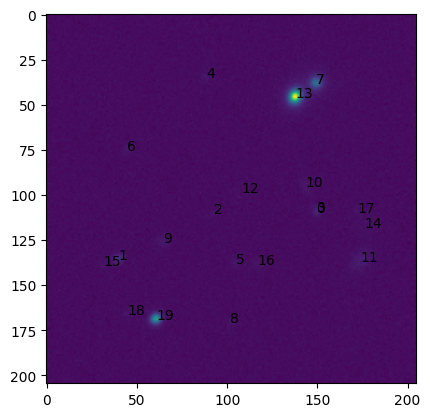

In [ ]:
# print("input_image")
band_num = 2
field_example_to_display = 0
plt.imshow(blend.blend_images[field_example_to_display, band_num])
for i in range(len(blend.catalog_list[field_example_to_display])):
    plt.text(
        blend.catalog_list[field_example_to_display]["x_peak"][i],
        blend.catalog_list[field_example_to_display]["y_peak"][i],
        str(i),
    )

input_image


<Figure size 1000x1000 with 0 Axes>

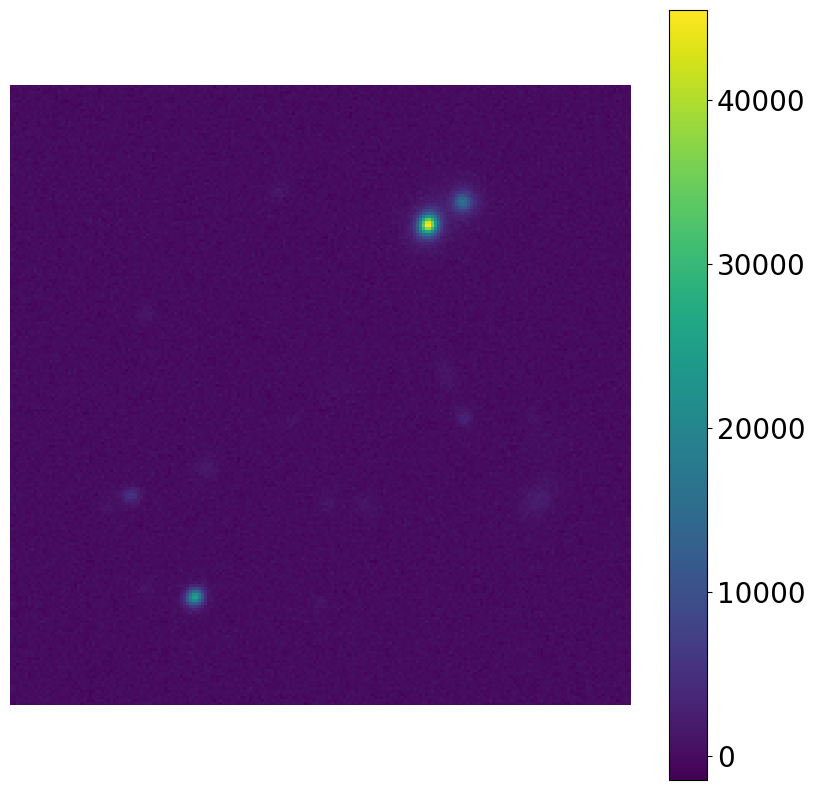

In [ ]:
fig = plt.figure(figsize=(10, 10))
print("input_image")
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
im1 = ax.imshow(blend.blend_images[field_example_to_display, 2])
# for i in range(len(blend['blend_list'][0])):
#    plt.scatter(blend['blend_list'][0]['x_peak'][i],
#                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")
# plt.text(blend['blend_list'][0]['x_peak'][i]-1, blend['blend_list'][0]['y_peak'][i]-1, str(i), c='black', fontsize=15)
bar = fig.colorbar(im1, ax=ax)
bar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("input field")

## Initialize the Deblender

In [ ]:
tf.get_logger().setLevel("ERROR")

weights_path = os.path.join(get_data_dir_path(), maddeb_config["survey_name"] + "0.01")
survey = galcheat.get_survey(maddeb_config["survey_name"])
deb = Deblend(weights_path=weights_path, survey=survey)

field = blend.blend_images

## Run MADNESS

In [ ]:
# Convergence and optimizer
convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(
    rtol=0.05,
    min_num_steps=40,
    window_size=15,
)

initial_lr = 0.025
if maddeb_config["survey_name"] == "LSST":
    initial_lr = 0.05

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=30,
    decay_rate=0.8,
    staircase=True,
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

In [ ]:
# detected positions
detected_positions = np.zeros((len(blend.catalog_list), max_number, 2))
num_components = []
for field_num in range(len(blend.catalog_list)):
    for gal_num in range(len(blend.catalog_list[field_num])):
        detected_positions[field_num][gal_num][0] = blend.catalog_list[field_num][
            "y_peak"
        ][gal_num]
        detected_positions[field_num][gal_num][1] = blend.catalog_list[field_num][
            "x_peak"
        ][gal_num]
    num_components.append(len(blend.catalog_list[field_num]))

In [ ]:
# Running the optimizer
deb(
    blended_fields=blend.blend_images,
    detected_positions=detected_positions,
    num_components=num_components,
    linear_norm_coeff=linear_norm_coeff,
    max_iter=200,
    convergence_criterion=convergence_criterion,
    optimizer=optimizer,
    use_debvader=True,
)

use debvader: True

Using encoder for initial point
Time taken for initialization: 0.5419490337371826

--- Starting gradient descent in the latent space ---
Maximum number of iterations: 200
Number of fields: 4
Number of Galaxies: [20 14 12 16]
Dimensions of latent space: 16
--- Gradient descent complete ---
Time taken for gradient descent: 110.45233845710754


## Evaluate Results 

### Plot the log prior + log likelihood

Text(0, 0.5, 'loss')

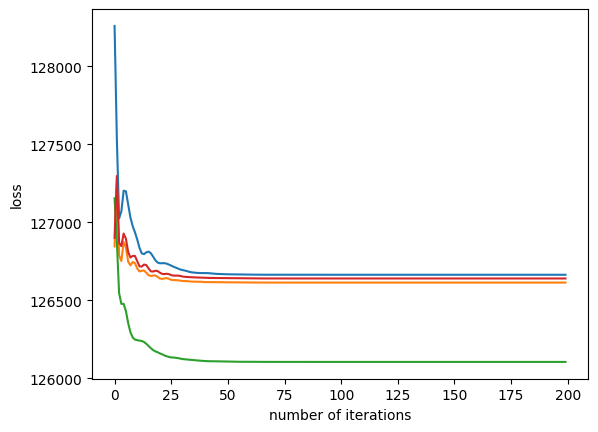

In [ ]:
plt.plot(deb.results)
plt.xlabel("number of iterations")
plt.ylabel("loss")

### See individual reconstructions

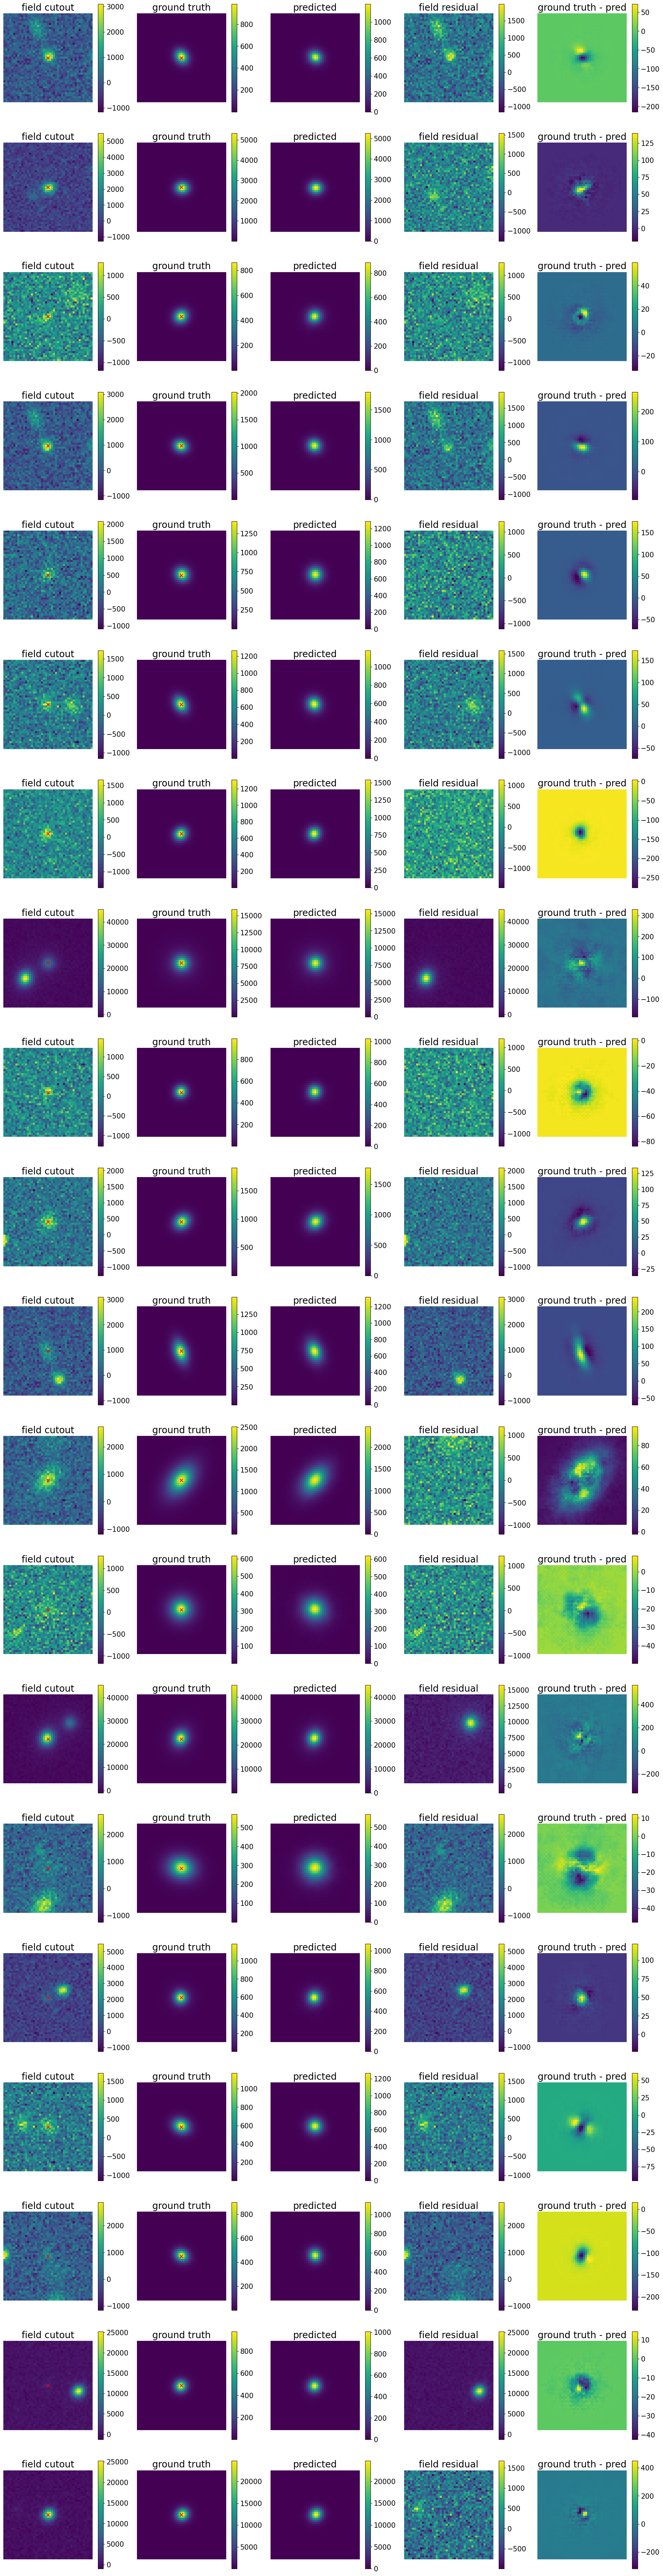

In [ ]:
fig, ax = plt.subplots(
    len(blend.catalog_list[field_example_to_display]),
    5,
    figsize=(5 * 5, 5 * len(blend.catalog_list[0])),
)

for i in range(len(blend.catalog_list[field_example_to_display])):

    field_cutout_r_band = extract_cutouts(
        blend.blend_images[field_example_to_display],
        [detected_positions[field_example_to_display][i]],
        distances_to_center=False,
        channel_last=False,
        cutout_size=45,
    )[0][0, :, :, 2]
    galaxy_cutout_r_band = extract_cutouts(
        blend.isolated_images[field_example_to_display][i],
        [detected_positions[field_example_to_display][i]],
        distances_to_center=False,
        cutout_size=45,
    )[0][0, :, :, 2]

    im1 = ax[i, 0].imshow(field_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 0].set_title("field cutout", fontsize=20)
    ax[i, 0].scatter(22, 22, c="r", marker="x")
    ax[i, 0].axis("off")

    im1 = ax[i, 1].imshow(galaxy_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 1].set_title("ground truth", fontsize=20)
    ax[i, 1].scatter(22, 22, c="r", marker="x")
    ax[i, 1].axis("off")

    im2 = ax[i, 2].imshow(deb.components[field_example_to_display][i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i, 2])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 2].set_title("predicted", fontsize=20)
    ax[i, 2].axis("off")

    im3 = ax[i, 3].imshow(
        field_cutout_r_band - deb.components[field_example_to_display][i][:, :, 2]
    )
    cbar = fig.colorbar(im3, ax=ax[i, 3])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 3].set_title("field residual", fontsize=20)
    ax[i, 3].axis("off")

    im3 = ax[i, 4].imshow(
        galaxy_cutout_r_band - deb.components[field_example_to_display][i][:, :, 2]
    )
    cbar = fig.colorbar(im3, ax=ax[i, 4])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 4].set_title("ground truth - pred", fontsize=20)
    ax[i, 4].axis("off")

plt.savefig("MAP_predictions")
plt.show()

### Plot residuals

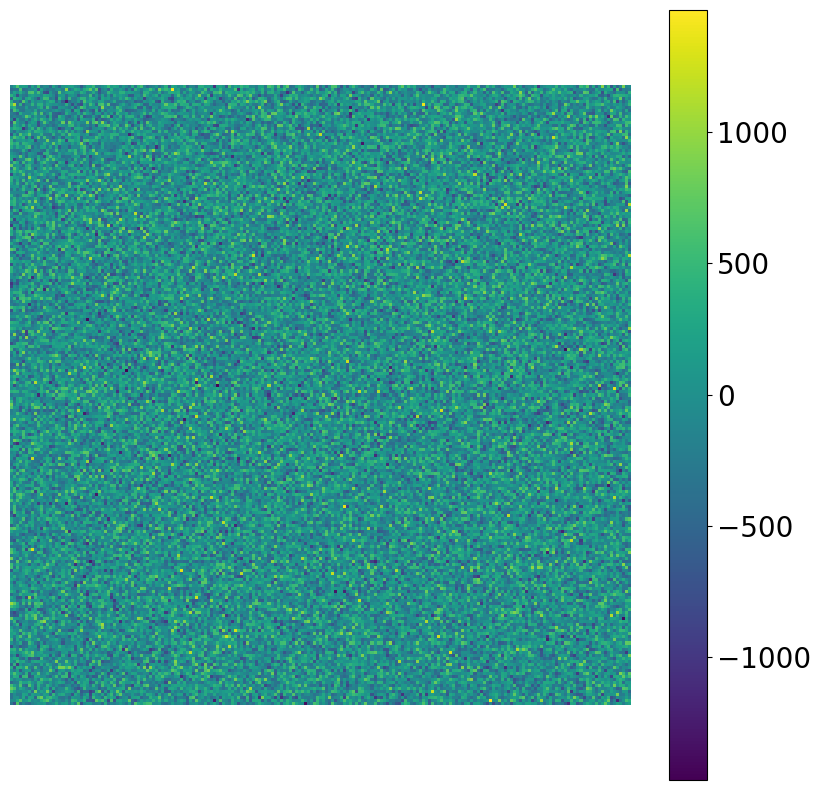

In [ ]:
# Residual after MADNESS run
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
tf.config.run_functions_eagerly(True)

padding_infos = deb.get_padding_infos()
index_pos_to_sub = deb.get_index_pos_to_sub()
residual = compute_residual(
    blended_field=np.transpose(
        blend.blend_images[field_example_to_display], axes=[1, 2, 0]
    ),
    reconstructions=deb.components[field_example_to_display],
    index_pos_to_sub=index_pos_to_sub[field_example_to_display],
    num_components=num_components[field_example_to_display],
).numpy()
# residual = np.transpose(deb.postage_stamp,
im1 = ax.imshow(residual[:, :, 2])
cbar = fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("residual")

# for i in range(len(blend['blend_list'][0])):
# plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", linewidths=.5, s=120, c="r")

### Final Reconstructed Field

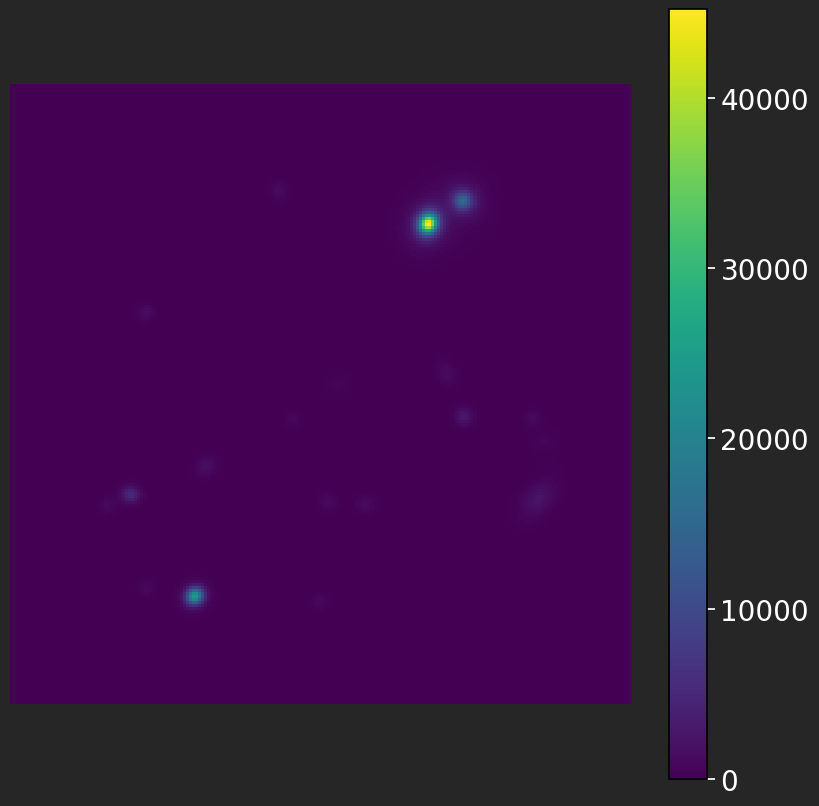

In [ ]:
sns.set_theme(
    style={
        "axes.grid": False,
        "axes.labelcolor": "white",
        "figure.facecolor": ".15",
        "xtick.color": "white",
        "ytick.color": "white",
        "text.color": "white",
        "image.cmap": "viridis",
    }
)
predicted_field = blend.blend_images[field_example_to_display] - np.transpose(
    residual, axes=[2, 0, 1]
)
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
im1 = ax.imshow(predicted_field[2, :, :])
cbar = fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.show();